<a href="https://colab.research.google.com/github/ronmin11/Verdis/blob/model-dev/verdis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
#import timm
from transformers import AutoModelForImageClassification, AutoModel
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

import seaborn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import kagglehub


In [ ]:
MODEL = "microsoft/resnet-18"

In [ ]:
path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'new-plant-diseases-dataset' dataset.
Path to dataset files: /kaggle/input/new-plant-diseases-dataset


In [ ]:
class ImageDataset(Dataset):
  def __init__(self,data_dir, transform=None):
    self.data = ImageFolder(data_dir, transform=transform)

  def __len__(self): #DataLoader will need to know how many examples we have in a dataset once we create it
    return len(self.data)

  def __getitem__(self,idx): #takes in index location in dataset and returns one item
    return self.data[idx] #returns data item of the index provided

  @property
  def classes(self):
    return self.data.classes

In [ ]:
#dataset = ImageDataset(data_dir=path)

In [ ]:
#len(dataset)

In [ ]:
#image,label = dataset[0]
#image

In [ ]:
#print(label) #angry

In [ ]:
import os

In [ ]:
#Dictionairy to associate output labels with their corresponding class
data_dir = os.path.join(path, "New Plant Diseases Dataset(Augmented)", "New Plant Diseases Dataset(Augmented)", "train")
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'Apple___Apple_scab', 1: 'Apple___Black_rot', 2: 'Apple___Cedar_apple_rust', 3: 'Apple___healthy', 4: 'Blueberry___healthy', 5: 'Cherry_(including_sour)___Powdery_mildew', 6: 'Cherry_(including_sour)___healthy', 7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 8: 'Corn_(maize)___Common_rust_', 9: 'Corn_(maize)___Northern_Leaf_Blight', 10: 'Corn_(maize)___healthy', 11: 'Grape___Black_rot', 12: 'Grape___Esca_(Black_Measles)', 13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 14: 'Grape___healthy', 15: 'Orange___Haunglongbing_(Citrus_greening)', 16: 'Peach___Bacterial_spot', 17: 'Peach___healthy', 18: 'Pepper,_bell___Bacterial_spot', 19: 'Pepper,_bell___healthy', 20: 'Potato___Early_blight', 21: 'Potato___Late_blight', 22: 'Potato___healthy', 23: 'Raspberry___healthy', 24: 'Soybean___healthy', 25: 'Squash___Powdery_mildew', 26: 'Strawberry___Leaf_scorch', 27: 'Strawberry___healthy', 28: 'Tomato___Bacterial_spot', 29: 'Tomato___Early_blight', 30: 'Tomato___Late_blight', 31: 'To

In [ ]:
train_dir = os.path.join(path, "New Plant Diseases Dataset(Augmented)", "New Plant Diseases Dataset(Augmented)", "train")
val_dir = os.path.join(path, "New Plant Diseases Dataset(Augmented)", "New Plant Diseases Dataset(Augmented)", "valid")
test_dir = os.path.join(path, "test")

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224,224)), #ViT pretrained model expects 224x224 input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

train_ds = ImageDataset(train_dir, transform) #apply transformations to dataset
val_ds = ImageDataset(val_dir, transform)
test_ds = ImageDataset(test_dir, transform)

DataLoaders

In [ ]:
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True) #will train faster
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)


PyTorch Model

In [ ]:
class ImageClassifier(nn.Module):
    def __init__(self, num_classes=38):
        super(ImageClassifier, self).__init__()
        # Use the classification model directly instead of base model
        self.model = AutoModelForImageClassification.from_pretrained(
            MODEL,
            num_labels=num_classes,
            ignore_mismatched_sizes=True  # Allow replacing the classification head
        )

    def forward(self, x):
        output = self.model(pixel_values=x, return_dict=True)
        return output.logits

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
model = ImageClassifier(num_classes=38)


Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-18 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([38]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 512]) in the checkpoint and torch.Size([38, 512]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#print(model)

In [ ]:
"""
for images, labels in dataloader:
  break

model(images)
"""

'\nfor images, labels in dataloader:\n  break\n\nmodel(images)\n'

Training

In [ ]:
SEED = 42
BATCH_SIZE = 32
np.random.seed(SEED)
torch.manual_seed(SEED)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-4)

In [ ]:
EPOCHS = 3
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Move model to GPU
model.to(device)

for epoch in range(EPOCHS):
    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_dl, desc=f"Epoch {epoch+1}/{EPOCHS} - Training"):
        # Move data to GPU
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_dl.dataset)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(val_dl, desc=f"Epoch {epoch+1}/{EPOCHS} - Validation"):
            # Move data to GPU
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / len(val_dl.dataset)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{EPOCHS} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} - "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    # Save checkpoint after each epoch
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
    }, f'checkpoint_epoch_{epoch+1}.pth')

Epoch 1/3 - Training:   0%|          | 0/2197 [00:00<?, ?it/s]

Epoch 1/3 - Validation:   0%|          | 0/550 [00:00<?, ?it/s]

Epoch 1/3 - Train Loss: 0.1511, Train Acc: 0.9661 - Val Loss: 0.0216, Val Acc: 0.9933


Epoch 2/3 - Training:   0%|          | 0/2197 [00:00<?, ?it/s]

Epoch 2/3 - Validation:   0%|          | 0/550 [00:00<?, ?it/s]

Epoch 2/3 - Train Loss: 0.0280, Train Acc: 0.9921 - Val Loss: 0.0289, Val Acc: 0.9917


Epoch 3/3 - Training:   0%|          | 0/2197 [00:00<?, ?it/s]

Epoch 3/3 - Validation:   0%|          | 0/550 [00:00<?, ?it/s]

Epoch 3/3 - Train Loss: 0.0202, Train Acc: 0.9948 - Val Loss: 0.0238, Val Acc: 0.9917


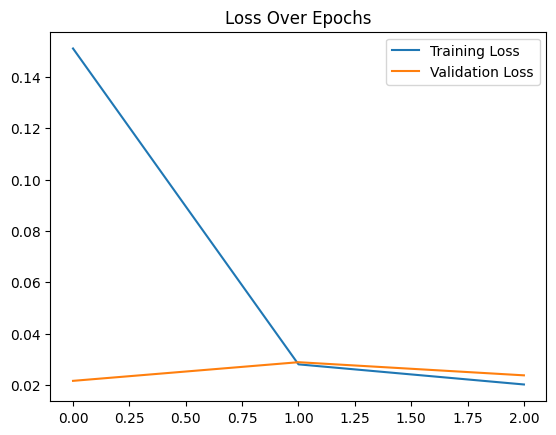

In [ ]:
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

In [ ]:
#Save weights
torch.save(model.state_dict(), "model_weights.pth")
print("Saved model weights to model_weights.pth")

Saved model weights to model_weights.pth


In [ ]:
#Save model
torch.save(model, "full_model.pth")
print("Saved full model to full_model.pth")

Saved full model to full_model.pth


Testing trained model on test dataset

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device, non_blocking=True)

def predict_image(img, model):
    """Converts image to array and return the predicted class
        with highest probability"""
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return target_to_class[preds[0].item()]

Label: AppleCedarRust1.JPG , Predicted: Apple___Cedar_apple_rust


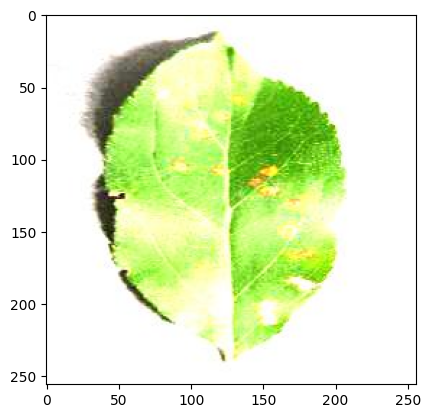

In [ ]:
test = ImageFolder(test_dir, transform=transforms.ToTensor())
test_images = sorted(os.listdir(test_dir + '/test'))
img, label = test[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_images[0], ', Predicted:', predict_image(img, model))

In [ ]:
for i, (img, label) in enumerate(test):
    print('Label:', test_images[i], ', Predicted:', predict_image(img, model))

Label: AppleCedarRust1.JPG , Predicted: Apple___Cedar_apple_rust
Label: AppleCedarRust2.JPG , Predicted: Apple___Cedar_apple_rust
Label: AppleCedarRust3.JPG , Predicted: Apple___Cedar_apple_rust
Label: AppleCedarRust4.JPG , Predicted: Apple___Cedar_apple_rust
Label: AppleScab1.JPG , Predicted: Apple___healthy
Label: AppleScab2.JPG , Predicted: Apple___healthy
Label: AppleScab3.JPG , Predicted: Corn_(maize)___healthy
Label: CornCommonRust1.JPG , Predicted: Soybean___healthy
Label: CornCommonRust2.JPG , Predicted: Corn_(maize)___Northern_Leaf_Blight
Label: CornCommonRust3.JPG , Predicted: Corn_(maize)___Northern_Leaf_Blight
Label: PotatoEarlyBlight1.JPG , Predicted: Tomato___Bacterial_spot
Label: PotatoEarlyBlight2.JPG , Predicted: Tomato___Bacterial_spot
Label: PotatoEarlyBlight3.JPG , Predicted: Tomato___Bacterial_spot
Label: PotatoEarlyBlight4.JPG , Predicted: Orange___Haunglongbing_(Citrus_greening)
Label: PotatoEarlyBlight5.JPG , Predicted: Soybean___healthy
Label: PotatoHealthy1.JP

In [ ]:
# Testing loop
model.eval()  # Set the model to evaluation mode
running_loss = 0.0
correct = 0
total = 0

with torch.no_grad():  # Disable gradient calculation
    for images, labels in tqdm(test_dl, desc="Testing"):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = loss_fn(outputs, labels)
        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_loss = running_loss / len(test_dl.dataset)
test_accuracy = correct / total

print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}")

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Test Loss: 14.3951, Test Acc: 0.0909
